# Classification - Word2Vec

This notebook discusses Multi-label classification methods for the [academia.stackexchange.com](https://academia.stackexchange.com/) data dump in [Word2Vec](https://radimrehurek.com/gensim_3.8.3/models/word2vec.html) representation.

## Table of Contents
* [Data import](#data_import)
* [Data preparation](#data_preparation)
* [Methods](#methods)
* [Evaluation](#evaluation)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from joblib import dump, load
from pathlib import Path
from academia_tag_recommender.definitions import MODELS_PATH
from academia_tag_recommender.classifier import Classifier, available_classifier_paths

DATA_FOLDER = Path(MODELS_PATH) / 'classifier' / 'multi-label'
RANDOM_STATE = 0

<a id='data_import'/>

## Data import

In [2]:
from academia_tag_recommender.data import documents
from academia_tag_recommender.test_train_data import get_y, get_test_train_data

def get_X():
    return np.vstack([document.text for document in documents])

X_train, X_test, y_train, y_test = get_test_train_data(get_X(), get_y(), scale=False)
print('Train set with shape ', X_train.shape)
print('Test set with shape', X_test.shape)

Train set with shape  (24812, 1)
Test set with shape (8270, 1)


<a id='data_preparation'/>

## Data Preparation

In [3]:
from academia_tag_recommender.embedded_data import word2vec

In [4]:
from academia_tag_recommender.preprocessing_definition import PreprocessingDefinition
preprocessing = PreprocessingDefinition('word2vec', 'basic', 'basic', 'english', '1,1', 'None')
paths = available_classifier_paths('word2vec')

def create_classifier(classifier, name, vector_size=100):
    path = [path for path in paths if name in path.name and 'word2vec' in path.name]
    if len(path) > 0:
        clf = load(path[0])
    else:
        clf = Classifier(classifier, preprocessing, name)
        X_train_, X_test_ = word2vec(X_train, X_test, vector_size=vector_size, sg=True)
        clf.fit(X_train_, y_train)
        clf.score(X_test_, y_test)
        clf.save('word2vec')
    print('Training: {}s'.format(clf.training_time))
    print('Test: {}s'.format(clf.test_time))
    clf.evaluation.print_stats()

<a id='methods'/>

## Methods

* [Problem Transformation](#problem_transformation)
* [Algorithm Adaption](#algorithm_adaption)
* [Ensembles](#ensembles)

<a id='problem_transformation'/>

### Problem Transformation

- [DecisionTreeClassifier](#decisiontree)
- [KNeighborsClassifier](#kNN)
- [MLPClassifier](#mlp)
- [MultioutputClassifier](#multioutput)
- [Classwise Classifier](#classwise)
- [Classifier Chain](#chain)
- [Label Powerset](#label_powerset)

<a id='decisiontree'/>

**DecisionTreeClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

In [5]:
from sklearn.tree import DecisionTreeClassifier

create_classifier(DecisionTreeClassifier(random_state=RANDOM_STATE), 'DecisionTreeClassifier')

Training: 69.66712355613708s
Test: 0.06283330917358398s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.02203207535161968      0.009068923821039904     0.19358726320032246      0.18741031841999195      0.17337834206637107      
micro                                                            0.18005604857543203      0.18428223146421913      0.18214462897776937      
macro                                                            0.08362911726851692      0.08503988169492059      0.08387354012766245      


<a id='kNN'/>

**KNeighborsClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

In [6]:
from sklearn.neighbors import KNeighborsClassifier

create_classifier(KNeighborsClassifier(), 'KNeighborsClassifier')

Training: 1.2815711498260498s
Test: 87.50452399253845s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01325590275568001      0.05356711003627569      0.3449617089883112       0.19887142281338172      0.23523924684746933      
micro                                                            0.505801959773079        0.18753286485969692      0.27361813426329556      
macro                                                            0.30578054395634885      0.07741065727025662      0.1101510082268487       


<a id='mlp'/>

**MLPClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

In [7]:
from sklearn.neural_network import MLPClassifier

create_classifier(MLPClassifier(random_state=RANDOM_STATE), 'MLPClassifier')

Training: 167.28474855422974s
Test: 0.1216733455657959s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011680773881499396     0.08029020556227327      0.45898831116485284      0.2701531640467553       0.31741981919732826      
micro                                                            0.6596141879278158       0.2533581911181223       0.3660979484699869       
macro                                                            0.45266259424067956      0.13994222726678054      0.1912076391874365       


<a id='multioutput'/>

**MultioutputClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html#sklearn.multioutput.MultiOutputClassifier)

MultiouputClassifier transforms sklearn classifier into classifiers capable of Binary Relevence.

In [8]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC

create_classifier(MultiOutputClassifier(LinearSVC(random_state=RANDOM_STATE)), 'MultioutputClassifier(LinearSVC)')

Training: 39.016066789627075s
Test: 0.7410295009613037s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01201107363329727      0.06711003627569528      0.3382789197904071       0.18149334945586457      0.22144344638298688      
micro                                                            0.7046                   0.16841149194512167      0.2718469076739072       
macro                                                            0.24421456087251606      0.058888398417237336     0.08212297240388647      


In [9]:
from sklearn.linear_model import LogisticRegression

create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)')

Training: 31.497159719467163s
Test: 0.8387715816497803s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012215999490867435     0.06118500604594922      0.3184723901652559       0.17028617492946393      0.2074044644056736       
micro                                                            0.6743527508090615       0.15937664324298484      0.2578200518114681       
macro                                                            0.2399293291846852       0.04714134651423043      0.06869059156569282      


<a id='chain'/>

**Classifier Chain** [source](http://scikit.ml/api/skmultilearn.problem_transform.cc.html#skmultilearn.problem_transform.ClassifierChain)

<cite>[Read et al., 2011][1]</cite>

[1]: https://doi.org/10.1007/s10994-011-5256-5

In [10]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.svm import LinearSVC

create_classifier(ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)), 'ClassifierChain(LinearSVC)')

Training: 63.03010034561157s
Test: 3.2414655685424805s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011895882390377395     0.07267230955259976      0.38905683192261187      0.2125050382910117       0.2575492792844667       
micro                                                            0.684140896312221        0.19776279936899469      0.30683082400059336      
macro                                                            0.28866606726492267      0.07327175742597308      0.10148720470089305      


In [11]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
create_classifier(ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)), 'ClassifierChain(LogisticRegression)')

Training: 61.34348678588867s
Test: 2.595198392868042s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012175268885636097     0.06348246674727932      0.3581479242241032       0.1960802095929061       0.23680246060536267      
micro                                                            0.651269035532995        0.1839954108705005       0.2869283238286928       
macro                                                            0.2651126431360227       0.05410855801196146      0.07728401708821114      


<a id='label_powerset'/>

**Label Powerset** [source](http://scikit.ml/api/skmultilearn.problem_transform.lp.html#skmultilearn.problem_transform.LabelPowerset)

In [12]:
from skmultilearn.problem_transform import LabelPowerset

#create_classifier(LabelPowerset(classifier=LinearSVC(random_state=RANDOM_STATE)), 'LabelPowerset(LinearSVC)')

In [13]:
# Does not finish
#create_classifier(LabelPowerset(classifier=LogisticRegression(random_state=RANDOM_STATE)), 'LabelPowerset(LogisticRegression)')

<a id='Algorithm Adaption'/>

### Algorithm Adaption

- [MLkNN](#mlknn)
- [MLARAM](#mlaram)

<a id='mlknn'/>

**MLkNN** [source](http://scikit.ml/api/skmultilearn.adapt.mlknn.html#multilabel-k-nearest-neighbours)

> Firstly, for each test instance, its k nearest neighbors in the training set are identified. Then, according to statistical information gained from the label sets of these neighboring instances, i.e. the number of neighboring instances belonging to each possible class, maximum a posteriori (MAP) principle is utilized to determine the label set for the test instance.
<cite>[Zhang & Zhou, 2007][1]</cite>

[1]: https://doi.org/10.1016/j.patcog.2006.12.019

In [14]:
from skmultilearn.adapt import MLkNN

create_classifier(MLkNN(), 'MLkNN')

Training: 283.43229627609253s
Test: 74.32217502593994s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012804684019601604     0.06178960096735187      0.33696090286174935      0.1877992744860943       0.22518080267173374      
micro                                                            0.5617369803739762       0.17376547636120274      0.26542533771449434      
macro                                                            0.2868059428028904       0.08399799415864458      0.11735862694472192      


<a id='mlaram'/>

**MLARAM** [source](http://scikit.ml/api/skmultilearn.adapt.mlaram.html#skmultilearn.adapt.MLARAM)

> an extension of fuzzy Adaptive Resonance Associative Map (ARAM) – an Adaptive Resonance Theory (ART)based neural network. It aims at speeding up the classification process in the presence of very large data.
<cite>[F. Benites & E. Sapozhnikova, 2015][7]</cite>

[7]: https://doi.org/10.1109/ICDMW.2015.14

In [15]:
from skmultilearn.adapt import MLARAM

create_classifier(MLARAM(), 'MLARAM')

Training: 40.55542850494385s
Test: 268.6523907184601s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.017282504932221728     0.033736396614268443     0.4003092923467772       0.30345626763401856      0.3061574033248761       
micro                                                            0.329841217875266        0.2889717481715187       0.30805687203791465      
macro                                                            0.20290689925220143      0.14110802073434264      0.15187700168638296      


<a id='ensembles'/>

### Ensembles

- [RAkELo](#rakelo)
- [RAkELd](#rakeld)
- [MajorityVotingClassifier](#majority_voting)
- [LabelSpacePartitioningClassifier](#label_space)

<a id='rakelo'/>

**RAkELo** [source](http://scikit.ml/api/skmultilearn.ensemble.rakelo.html#skmultilearn.ensemble.RakelO)

> Rakel: randomly breaking the initial set of labels into a number of small-sized labelsets, and employing [Label powerset] to train a corresponding multilabel classifier.
<cite>[Tsoumakas et al., 2011][1]</cite>


> Divides the label space in to m subsets of size k, trains a Label Powerset classifier for each subset and assign a label to an instance if more than half of all classifiers (majority) from clusters that contain the label assigned the label to the instance.
<cite>[skmultilearn][2]</cite>


[1]: https://doi.org/10.1109/TKDE.2010.164
[2]: http://scikit.ml/api/skmultilearn.ensemble.rakelo.html#skmultilearn.ensemble.RakelO

In [16]:
from skmultilearn.ensemble import RakelO
from sklearn.svm import LinearSVC

create_classifier(RakelO(
    base_classifier=LinearSVC(random_state=RANDOM_STATE),
    model_count=y_train.shape[1]
), 'RakelO(LinearSVC)')

Training: 309.8258934020996s
Test: 123.45570588111877s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012148539425953033     0.06275695284159613      0.3090890769850867       0.16055622732769045      0.19853428916911384      
micro                                                            0.7082385070550751       0.14876428127539557      0.24588156283332677      
macro                                                            0.1779659920033633       0.041515383481645504     0.05894601258153098      


In [17]:
from sklearn.linear_model import LogisticRegression

create_classifier(RakelO(
    base_classifier=LogisticRegression(random_state=RANDOM_STATE),
    model_count=y_train.shape[1]
), 'RakelO(LogisticRegression)')

Training: 373.6394512653351s
Test: 123.84935545921326s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01209953541653408      0.0645707376058041       0.3430209592906086       0.18686618299072952      0.22610036275695283      
micro                                                            0.6763454780839653       0.17481715187150437      0.27782420420876697      
macro                                                            0.2653974545205705       0.057329394305700214     0.08312016876608101      


<a id='rakeld'/>

**RAkELd** [source](http://scikit.ml/api/skmultilearn.ensemble.rakeld.html#skmultilearn.ensemble.RakelD)

>Divides the label space in to equal partitions of size k, trains a Label Powerset classifier per partition and predicts by summing the result of all trained classifiers.
<cite>[skmultilearn][3]</cite>

[3]: http://scikit.ml/api/skmultilearn.ensemble.rakeld.html#skmultilearn.ensemble.RakelD

In [18]:
from skmultilearn.ensemble import RakelD

create_classifier(RakelD(base_classifier=LinearSVC(random_state=RANDOM_STATE)), 'RakelD(LinearSVC)')

Training: 70.4683358669281s
Test: 38.26806831359863s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012181633042703494     0.06178960096735187      0.3074566706972995       0.15934502216848045      0.19715322162722407      
micro                                                            0.7020454545454545       0.1476648023328075       0.24400647734902642      
macro                                                            0.16632680331945207      0.04163981299739647      0.05861340753411043      


In [19]:
create_classifier(RakelD(base_classifier=LogisticRegression(random_state=RANDOM_STATE)), 'RakelD(LogisticRegression)')

Training: 93.76913189888s
Test: 38.7243971824646s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012069623878317316     0.06481257557436518      0.3454675534058847       0.19045344619105198      0.229320454501833        
micro                                                            0.6769927536231884       0.17864142645441944      0.2826884526646242       
macro                                                            0.2791566258903509       0.059788456177421914     0.08652803634100069      


***Clustering***

In [20]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from academia_tag_recommender.test_train_data import get_all_labels

def get_graph_builder():
    graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
    label_names = get_all_labels()
    edge_map = graph_builder.transform(y_train)
    print("{} labels, {} edges".format(len(label_names), len(edge_map)))
    return graph_builder

In [21]:
from skmultilearn.cluster import IGraphLabelGraphClusterer
import igraph as ig

def get_clusterer():
    graph_builder = get_graph_builder()
    clusterer_igraph = IGraphLabelGraphClusterer(graph_builder=graph_builder, method='walktrap')
    partition = clusterer_igraph.fit_predict(X_train, y_train)
    return clusterer_igraph

In [22]:
clusterer_igraph = get_clusterer()

190 labels, 7725 edges


<a id='majority_vorting'/>

**MajorityVotingClassifier** [source](http://scikit.ml/api/skmultilearn.ensemble.voting.html#skmultilearn.ensemble.MajorityVotingClassifier)

In [23]:
from skmultilearn.ensemble.voting import MajorityVotingClassifier
from skmultilearn.problem_transform import ClassifierChain

create_classifier(MajorityVotingClassifier(
    classifier=ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)),
    clusterer=clusterer_igraph
), 'MajorityVotingClassifier(ClassifierChain(LogisticRegression))')

Training: 202.8807225227356s
Test: 5.398867607116699s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012094444090880162     0.06432889963724304      0.35172309552599756      0.18516928657799275      0.2277021554288785       
micro                                                            0.6790723770338507       0.17357426263205697      0.27647909845427543      
macro                                                            0.2846659916216136       0.057504343742206136     0.08445369514909853      


In [24]:
create_classifier(MajorityVotingClassifier(
    classifier=ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)),
    clusterer=clusterer_igraph
), 'MajorityVotingClassifier(ClassifierChain(LinearSVC))')

Training: 415.5837662220001s
Test: 5.977576732635498s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012145993763126074     0.061305925030229746     0.31531640467553407      0.15931882305521963      0.19905568031323775      
micro                                                            0.7100320659642694       0.14819064008795832      0.24520466679849715      
macro                                                            0.239738671507823        0.05156089587463357      0.07450814439261488      


<a id='label_space'/>

**LabelSpacePartitioningClassifier** [source](http://scikit.ml/api/skmultilearn.ensemble.partition.html#skmultilearn.ensemble.LabelSpacePartitioningClassifier)

<cite>[Szymański et al., 2016][2]</cite>

[2]: https://doi.org/10.3390/e18080282

In [25]:
from skmultilearn.ensemble import LabelSpacePartitioningClassifier

create_classifier(LabelSpacePartitioningClassifier(
    classifier = ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)),
    clusterer = clusterer_igraph
), 'LabelSpacePartitioningClassifier(ClassifierChain(LogisticRegression))')

Training: 198.79365706443787s
Test: 2.548816442489624s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012094444090880162     0.06432889963724304      0.35172309552599756      0.18516928657799275      0.2277021554288785       
micro                                                            0.6790723770338507       0.17357426263205697      0.27647909845427543      
macro                                                            0.2846659916216136       0.057504343742206136     0.08445369514909853      


In [26]:
create_classifier(LabelSpacePartitioningClassifier(
    classifier = ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)),
    clusterer = clusterer_igraph
), 'LabelSpacePartitioningClassifier(ClassifierChain(LinearSVC))')

Training: 412.5597360134125s
Test: 2.336864471435547s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012145993763126074     0.061305925030229746     0.31531640467553407      0.15931882305521963      0.19905568031323775      
micro                                                            0.7100320659642694       0.14819064008795832      0.24520466679849715      
macro                                                            0.239738671507823        0.05156089587463357      0.07450814439261488      


<a id='evaluation'/>

## Evaluation

In [27]:
paths = available_classifier_paths('word2vec')

In [28]:
evals = []
paths = [path for path in paths if '-' not in path.name]
for path in paths:
    clf = load(path)
    evaluation = clf.evaluation
    evals.append([str(clf), evaluation])

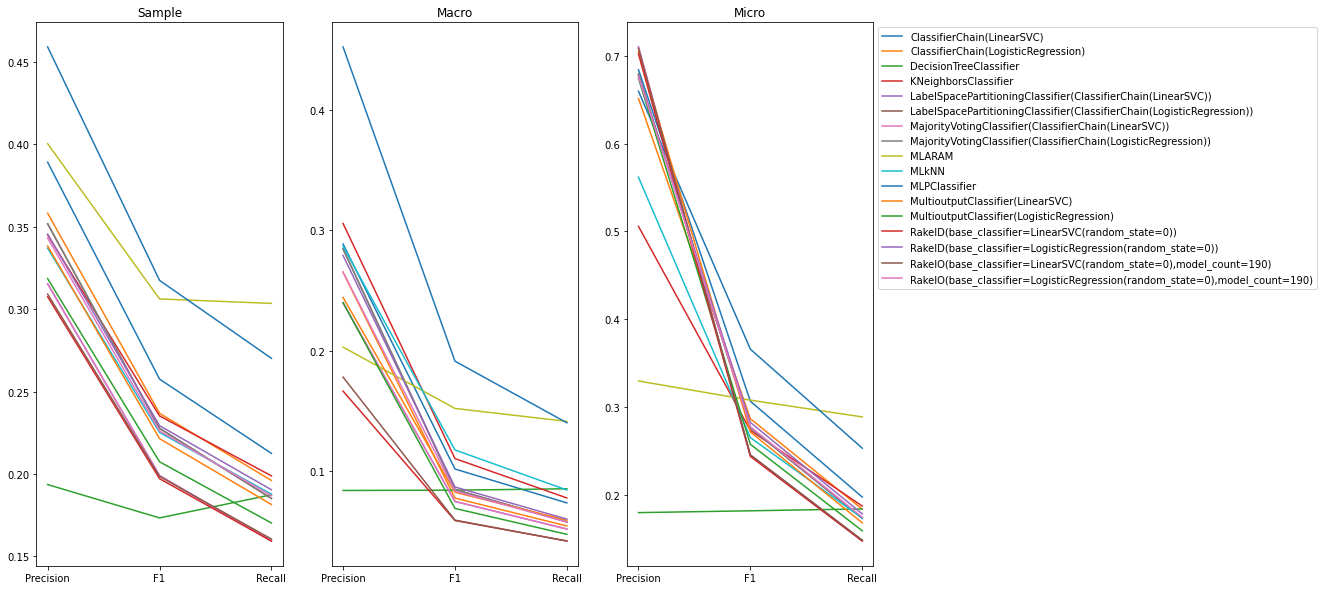

In [29]:
x_ = ['Precision', 'F1', 'Recall']
fig, axes = plt.subplots(1, 3, figsize=(15,10))
axes[0].set_title('Sample')
axes[1].set_title('Macro')
axes[2].set_title('Micro')
for eval_ in evals:
    evaluator = eval_[1]
    axes[0].plot(x_, [evaluator.precision_samples, evaluator.f1_samples, evaluator.recall_samples], label=eval_[0])
    axes[1].plot(x_, [evaluator.precision_macro, evaluator.f1_macro, evaluator.recall_macro], label=eval_[0])
    axes[2].plot(x_, [evaluator.precision_micro, evaluator.f1_micro, evaluator.recall_micro], label=eval_[0])
axes[2].legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

In [30]:
top_3 = sorted(paths, key=lambda x: load(x).evaluation.recall_macro, reverse=True)[:3]

In [31]:
def per_label_accuracy(orig, prediction):
    if not isinstance(prediction, np.ndarray):
        prediction = prediction.toarray()
    l = 1 - orig - prediction
    return np.average(l, axis=0)

In [32]:
from sklearn.metrics import classification_report
classwise_results = []
for clf_path in top_3:
    clf = load(clf_path)
    _, X_test_ = word2vec(X_train, X_test)
    prediction = clf.predict(X_test_)
    label_accuracies = per_label_accuracy(y_test, prediction)
    report = classification_report(y_test, prediction, output_dict=True, zero_division=0)
    classwise_report = {}
    for i, result in enumerate(report):
        if i < len(label_accuracies):
            classwise_report[result] = report[result]
            classwise_report[result]['accuracy'] = label_accuracies[int(result)]
    classwise_results.append((clf, classwise_report))

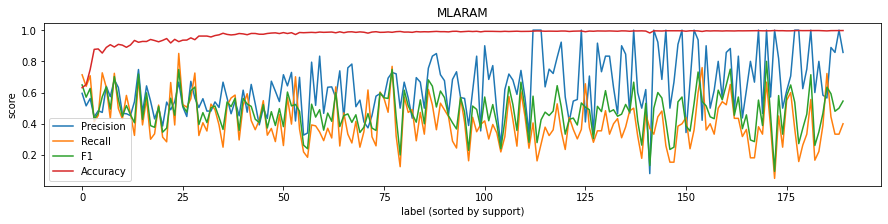

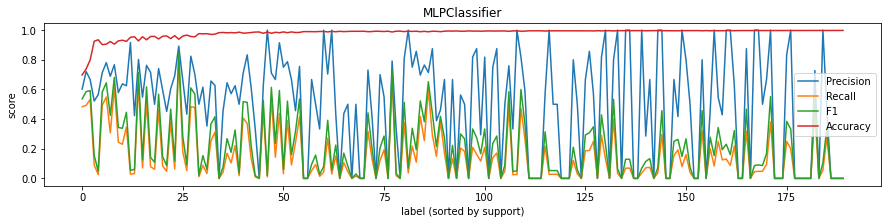

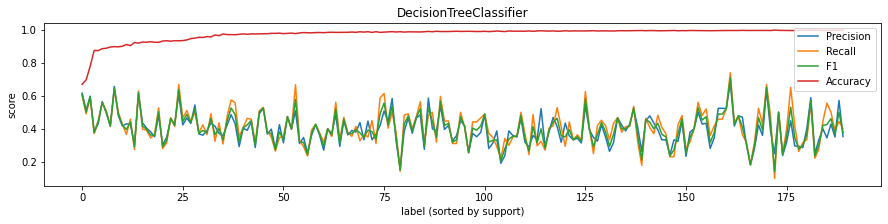

In [33]:
import numpy as np
x_ = np.arange(0, len(y_test[0]))
for classwise_result in classwise_results:
    name, results = classwise_result
    _, fig_1 = plt.subplots(figsize=(15,3))
    fig_1.set_title(name)
    sorted_results = sorted(results, key=lambda x: results[x]['support'], reverse=True)
    fig_1.plot(x_, [results[result]['precision'] for result in sorted_results][0:len(x_)], label='Precision')
    fig_1.plot(x_, [results[result]['recall'] for result in sorted_results][0:len(x_)], label='Recall')
    fig_1.plot(x_, [results[result]['f1-score'] for result in sorted_results][0:len(x_)], label='F1')
    fig_1.plot(x_, [results[result]['accuracy'] for result in sorted_results][0:len(x_)], label="Accuracy")
    fig_1.set_xlabel('label (sorted by support)')
    fig_1.set_ylabel('score')
    fig_1.legend(loc='best')
plt.show()

**Impact of vector size**

In [34]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)-100', 100)

Training: 38.41702580451965s
Test: 1.6502304077148438s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012410106281423026     0.06553808948004837      0.25455461507456667      0.1344054816606207       0.1646199689065469       
micro                                                            0.681038961038961        0.12549057145592035      0.2119301648884578       
macro                                                            0.21766281220593653      0.03184741093174244      0.048871400610936915     


In [ ]:
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)-200', 200)

In [ ]:
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)-500', 500)

In [ ]:
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)-1000', 1000)

In [ ]:
paths = available_classifier_paths('word2vec')
evals = []
for path in paths:
    if 'MultioutputClassifier(LogisticRegression)-' in str(path):
        clf = load(path)
        evaluation = clf.evaluation
        evals.append([int(str(clf.name_prefix).strip('MultioutputClassifier(LogisticRegression)-')), evaluation])

In [ ]:
fig, axes = plt.subplots(figsize=(15,10))
axes.set_title('Sample')
evals = sorted(evals, key=lambda x: x[0])
x_ = [eval[0] for eval in evals]
axes.plot(x_, [eval[1].f1_macro for eval in evals], label='F1 Macro')
axes.plot(x_, [eval[1].recall_macro for eval in evals], label='Recall Macro')
axes.plot(x_, [eval[1].precision_macro for eval in evals], label='Precision Macro')
axes.legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()